In [99]:
# 라이브러리
import os
import re
import random
import math
import cv2

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Activation, Add, AveragePooling2D
from tensorflow.keras.models import Model

import warnings
warnings.filterwarnings(action='ignore')

In [100]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # 메모리 사용 제한을 위한 설정
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    # 특정 GPU만 사용하도록 설정
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
  except RuntimeError as e:
    # 프로그램 시작 후에는 GPU 설정을 변경할 수 없으므로
    # 런타임 오류 발생 시 예외 처리가 필요함
    print(e)

Num GPUs Available:  1


In [101]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [102]:
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180,180]

In [103]:
# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH  = ROOT_PATH + '/chest_xray/data/test/*/*'

In [104]:
# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 6

In [105]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

In [106]:
print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [107]:
# data combine
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# data split
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2, random_state =8 )

In [108]:
print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [109]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1082
Pneumonia images count in training set: 3103


In [110]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [111]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [112]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [113]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [114]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [115]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [116]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

In [117]:
print(TEST_IMAGE_COUNT)

624


In [118]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [124]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

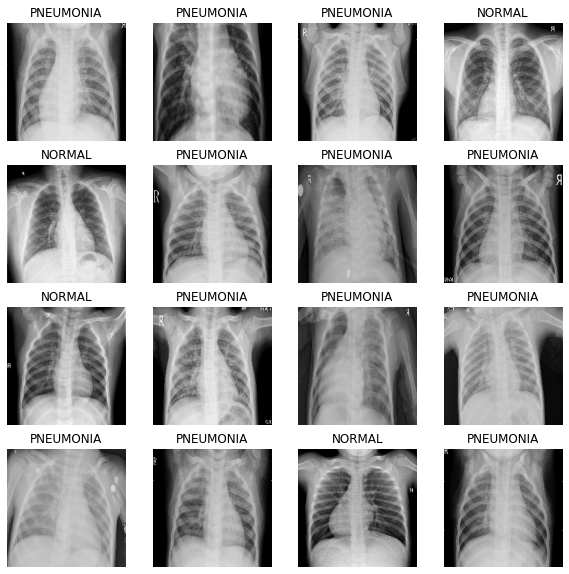

In [125]:
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [126]:
def resnet_block(inputs, filters, strides=(1, 1), use_conv_shortcut=False):
    shortcut = inputs
    if use_conv_shortcut:
        shortcut = Conv2D(filters, (1, 1), strides=strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Conv2D(filters, (3, 3), strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)

    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    return x

In [127]:
def resnet_18_binary(input_shape):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = resnet_block(x, filters=64, use_conv_shortcut=True)
    x = resnet_block(x, filters=64)
    x = resnet_block(x, filters=64)
    x = resnet_block(x, filters=64)
    

    x = resnet_block(x, filters=128, strides=(2, 2), use_conv_shortcut=True)
    x = resnet_block(x, filters=128)
    x = resnet_block(x, filters=128)
    x = resnet_block(x, filters=128)

    x = resnet_block(x, filters=256, strides=(2, 2), use_conv_shortcut=True)
    x = resnet_block(x, filters=256)
    x = resnet_block(x, filters=256)
    x = resnet_block(x, filters=256)


    x = resnet_block(x, filters=512, strides=(2, 2), use_conv_shortcut=True)
    x = resnet_block(x, filters=512)
    x = resnet_block(x, filters=512)
    x = resnet_block(x, filters=512)
    
    x  = AveragePooling2D(pool_size=(7, 7), strides=1, padding='same')(x)

    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)  # Binary classification output with sigmoid activation

    model = Model(inputs=inputs, outputs=x)
    return model

In [128]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.93
Weight for PNEUMONIA: 0.67


In [129]:
with tf.device('/GPU:0'):
    model = resnet_18_binary((180,180,3))

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [130]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d_185 (Conv2D)             (None, 90, 90, 64)   9472        input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_185 (BatchN (None, 90, 90, 64)   256         conv2d_185[0][0]                 
__________________________________________________________________________________________________
activation_165 (Activation)     (None, 90, 90, 64)   0           batch_normalization_185[0][0]    
____________________________________________________________________________________________

In [131]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/6
261/261 [==============================] - 66s 207ms/step - loss: 0.6141 - accuracy: 0.8542 - precision: 0.9439 - recall: 0.8540 - val_loss: 6.1122 - val_accuracy: 0.7442 - val_precision: 0.7442 - val_recall: 1.0000
Epoch 2/6
261/261 [==============================] - 53s 204ms/step - loss: 0.2501 - accuracy: 0.9016 - precision: 0.9657 - recall: 0.8993 - val_loss: 34.9290 - val_accuracy: 0.2538 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/6
261/261 [==============================] - 54s 207ms/step - loss: 0.2095 - accuracy: 0.9207 - precision: 0.9730 - recall: 0.9186 - val_loss: 0.9713 - val_accuracy: 0.7298 - val_precision: 0.9901 - val_recall: 0.6439
Epoch 4/6
261/261 [==============================] - 53s 205ms/step - loss: 0.2239 - accuracy: 0.9179 - precision: 0.9719 - recall: 0.9158 - val_loss: 4.5341 - val_accuracy: 0.2817 - val_precision: 0.9375 - val_recall: 0.0387
Epoch 5/6
261/261 [==============================] - 55s 210ms/step - loss: 0.5231 - ac

In [132]:
def draw_history(history):
    fig, ax = plt.subplots(1, 4, figsize=(20, 3))
    ax = ax.ravel()

    for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])

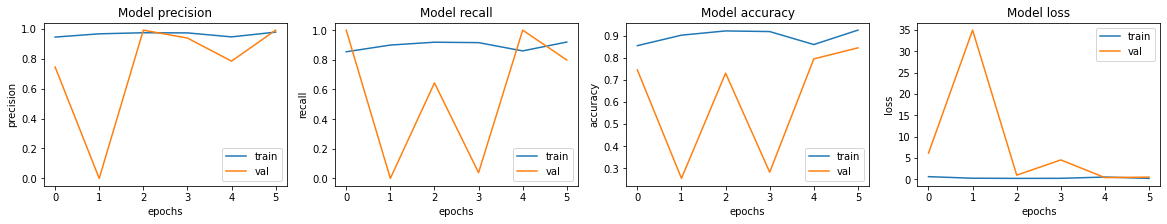

In [133]:
draw_history(history)

In [134]:
def print_evaluation(model, test_ds):
    loss, accuracy, precision, recall = model.evaluate(test_ds)
    print(f'Loss: {loss:.2f},\nAccuracy: {accuracy:.2f},\nPrecision: {precision:.2f},\nRecall: {recall:.2f}')

In [135]:
print_evaluation(model, test_ds)

39/39 [==============================] - 5s 126ms/step - loss: 0.6103 - accuracy: 0.7981 - precision: 0.8667 - recall: 0.8000
Loss: 0.61,
Accuracy: 0.80,
Precision: 0.87,
Recall: 0.80
